In [1]:
import sys
sys.path.append(r'C:/Users/ryoo/AppData/Local/gsas2main/GSAS-II')

import GSASII.GSASIIpath as GSASIIpath
GSASIIpath.binaryPath = r'C:/Users/ryoo/AppData/Local/gsas2main/GSAS-II/GSASII-bin/win_64_p3.13_n2.2'
GSASIIpath.SetBinaryPath(True)

import GSASII.GSASIIscriptable as G2sc
from GSASII import GSASIIspc as G2spc
from GSASII import GSASIIlattice as G2lat

import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
import numpy as np

6 values read from C:\Users\ryoo\.GSASII\config.ini
GSAS-II binary directory: C:\Users\ryoo\AppData\Local\gsas2main\GSAS-II\GSASII-bin\win_64_p3.13_n2.2


In [ ]:
"""
Create Pawley reflection from unit cell parameters from phase cif 
"""

def pawley_create(gpx, phase_name, dmin=None, dmax=None, neg_wt=0.0):
    ph  = gpx.phase(phase_name)
    gen = ph.data['General']
    SG  = gen['SGData']

    # d-range
    dmin = float(dmin if dmin is not None else gen.get('Pawley dmin', 1.0))
    dmax = float(dmax if dmax is not None else gen.get('Pawley dmax', 100.0))
    gen['doPawley']      = True
    gen['Pawley dmin']   = dmin
    gen['Pawley dmax']   = dmax
    gen['Pawley neg wt'] = float(neg_wt)

    # reciprocal matrix → hkl
    A6 = np.array(G2lat.cell2A(gen['Cell'][1:7]), float)  
    HKL_mult_list = G2lat.GenHLaue(dmin, SG, A6)
    rd2 = getattr(G2lat, 'calc_rDsq', getattr(G2lat, 'Calc_rDsq', None))

    pawley_refs = []
    for h,k,l,mul in HKL_mult_list:
        d = 1.0/np.sqrt(rd2([h,k,l], A6))
        if dmin <= d <= dmax:
            pawley_refs.append([float(h), float(k), float(l),
                                int(mul), float(d), False, 0.0, 1.0])

    pawley_refs.sort(key=lambda x: x[4], reverse=True)
    ph.data['Pawley ref'] = pawley_refs

    for hname, _ in ph.data.get('Histograms', {}).items():
        h = gpx.histogram(hname)
        h.data['Use'] = True
        h.data['LeBail'] = False
    return len(pawley_refs)

def _apply_refine_flags(ph, predicate, default=False):
    """predicate(h,k,l,mul,d,idx) → True 인 반사만 refine 체크"""
    refs = ph.data.get('Pawley ref', [])
    if not refs:
        print("No Pawley reflections found.")
        return 0
    n = 0
    for i, r in enumerate(refs):
        h, k, l, mul, d = int(r[0]), int(r[1]), int(r[2]), int(r[3]), float(r[4])
        flag = bool(predicate(h, k, l, mul, d, i))
        r[5] = flag if flag is not None else default
        n += int(r[5] is True)
    return n

def pawley_select_by_indices(gpx, phase_name, indices, on=True):
    idxset = set(indices)
    ph = gpx.phase(phase_name)
    _apply_refine_flags(ph, lambda h,k,l,mul,d,i: (i in idxset) == True and on, default=False)
    gpx.save()


def pawley_select_by_limit(gpx, phase_name, hist_index=0, wavelength=1.5406):
    """
    histogram의 Limits 범위 내에 있는 Pawley reflection만 refine하도록 설정
    
    Parameters:
    -----------
    gpx : G2Project
        GSAS-II project object
    phase_name : str
        Phase name
    hist_index : int
        Histogram index (default: 0)
    wavelength : float
        X-ray wavelength in Angstrom (default: 1.5406 for Cu K-alpha)
    
    Returns:
    --------
    int : Number of selected reflections
    """
    import numpy as np
    
    ph = gpx.phase(phase_name)
    hist = gpx.histogram(hist_index)
    
    # histogram limits
    limits = hist.data['Limits'][1]  # [min_2theta, max_2theta]
    min_2theta, max_2theta = limits[0], limits[1]
    
    # Pawley reflections 
    refs = ph.data.get('Pawley ref', [])
    if not refs:
        print("No Pawley reflections found.")
        return 0
    
    # d-spacing to 2theta
    def d_to_2theta(d, lam):
        theta = np.arcsin(lam / (2 * d))
        return 2 * np.degrees(theta)
    
    # using reflections in the limits range
    n_selected = 0
    for i, r in enumerate(refs):
        d = float(r[4])  # d-spacing in Angstrom
        two_theta = d_to_2theta(d, wavelength)
        
        # limits 범위 내에 있으면 refine flag를 True로
        if min_2theta <= two_theta <= max_2theta:
            r[5] = True
            n_selected += 1
        else:
            r[5] = False
    
    gpx.save()
    print(f"Selected {n_selected} reflections within 2θ range [{min_2theta:.2f}, {max_2theta:.2f}]")
    print(f"Using wavelength: {wavelength} Å")
    return n_selected

In [ ]:
def load_background_from_file(gpx, hist_index, background_file):
    """
    GSAS-II background parameter file (.pwdrbck)을 로드해서 histogram에 적용
    
    Parameters:
    -----------
    gpx : G2Project
        GSAS-II project object
    hist_index : int
        Histogram index
    background_file : str
        Path to .pwdrbck file
    """
    import ast
    
    hist = gpx.histogram(hist_index)
    
    with open(background_file, 'r') as f:
        lines = f.readlines()
    
    # Read background parameters 
    # ['chebyschev-1', True, 5, 13744.9516, -11410.0, 619.7199, 602.0776, 344.6025]
    bkg_line = lines[0].strip()
    if bkg_line.startswith('#'):
        bkg_line = lines[1].strip()
    
    bkg_params = ast.literal_eval(bkg_line)
    
    bkg_type = bkg_params[0]  # 'chebyschev-1'
    refine = bkg_params[1]     # True
    n_coeffs = bkg_params[2]   # 5
    coeffs = bkg_params[3:]    # [13744.9516, -11410.0, 619.7199, 602.0776, 344.6025]
    
    # background setting
    hist.set_refinements({
        "Background": {
            'type': bkg_type,
            'refine': refine,
            'no. coeffs': n_coeffs,
            'coeffs': coeffs
        }
    })
    
    gpx.save()
    print(f"Loaded background from {background_file}")
    print(f"Type: {bkg_type}, Coeffs: {n_coeffs}, Refine: {refine}")
    
    return bkg_params

In [3]:
"""
Visualize refinements
"""

def _get_bragg_positions(gpx, hist, phase_name):
    limits = hist.data['Limits'][1]
    hist_name = hist.name
    positions = []

    refl_lists = hist.data.get('Reflection Lists', {})
    if phase_name in refl_lists:
        for refl in refl_lists[phase_name].get('RefList', []):
            try:
                pos = float(refl[5])           # 2θ
                if limits[0] <= pos <= limits[1]:
                    positions.append(pos)
            except Exception:
                pass

    if not positions and phase_name in gpx.data.get('Phases', {}):
        ph = gpx.phase(phase_name)
        ph_hist = ph.data.get('Histograms', {}).get(hist_name, {})
        ref_list = ph_hist.get('RefList', ph_hist.get('Reflection List', []))
        for refl in ref_list:
            try:
                pos = float(refl[5])
                if limits[0] <= pos <= limits[1]:
                    positions.append(pos)
            except Exception:
                pass

    return sorted(positions)

def _set_robust_ylim(ax, x, ys, limits, pct=(0.5, 99.5), pad=0.05, floor=0):
    mask = (x >= limits[0]) & (x <= limits[1])
    vals = np.concatenate([np.asarray(y)[mask].ravel() for y in ys])
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        ax.relim(); ax.autoscale(axis='y'); return
    lo = np.nanpercentile(vals, pct[0])
    hi = np.nanpercentile(vals, pct[1])
    if floor is not None:
        lo = max(lo, floor)  
    if hi <= lo:  
        lo, hi = np.nanmin(vals), np.nanmax(vals)
    span = max(hi - lo, 1e-9)
    ax.set_ylim(lo - pad*span, hi + pad*span)

def plot_refinement_result_subplots(gpx, hist_index=0, phase_name=None, figsize=(12, 12)):
    hist = gpx.histogram(hist_index)
    hist_name = hist.name

    # 일관된 키 사용
    x      = hist.getdata('x')
    y_obs  = hist.getdata('yobs')
    y_calc = hist.getdata('ycalc')
    y_bkg  = hist.getdata('background')
    y_diff = hist.getdata('residual')

    limits = hist.data['Limits'][1]

    if phase_name is None:
        phase_names = list(gpx.data.get('Phases', {}).keys())
        if phase_names:
            phase_name = phase_names[0]

    bragg_positions = []
    if phase_name:
        bragg_positions = _get_bragg_positions(gpx, hist, phase_name)
        print(f"Final bragg_positions: {bragg_positions}")

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True,
                             gridspec_kw={'height_ratios': [3, 1, 1, 0.5]})

    ax1 = axes[0]
    ax1.plot(x, y_obs, 'b+', markersize=4, label='obs', alpha=0.7)
    ax1.plot(x, y_calc, 'g-', linewidth=2, label='calc')
    ax1.plot(x, y_bkg, 'r-', linewidth=1.5, label='bkg')
    ax1.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax1.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax1.set_ylabel('Intensity')
    ax1.set_title(hist_name)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    _set_robust_ylim(ax1, x, [y_obs, y_calc, y_bkg], limits, pct=(0.5, 99.5), pad=0.05, floor=0)
    
    ax2 = axes[1]
    ax2.plot(x, y_diff, 'c-', linewidth=1.5, label='diff')
    ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    ax2.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax2.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax2.set_ylabel('Difference')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[2]
    ax3.plot(x, y_bkg, 'r-', linewidth=2, label='background')
    ax3.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax3.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax3.set_ylabel('Background')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    ax4 = axes[3]
    if bragg_positions:
        lc = ax4.vlines(bragg_positions, -0.4, 0.4,
                        color='tab:blue', linewidth=2,
                        label=f'{phase_name} Bragg peaks')

        ax4.legend(loc = 'upper right', handler_map={LineCollection: HandlerLineCollection(numpoints=2)})
    else:
        ax4.text(0.5, 0.5, 'No Bragg peaks found', transform=ax4.transAxes,
                 ha='center', va='center', fontsize=10, color='gray')
    ax4.set_ylim(-0.5, 0.5)
    ax4.set_yticks([])
    ax4.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax4.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlabel('2θ')

    for ax in axes:
        ax.set_xlim(limits[0] - 0.2, limits[1] + 0.2)

    plt.tight_layout()
    plt.show()
    return fig, axes

In [62]:
import numpy as np
# filename = r'C:/Users/ryoo/Desktop/LDRD/XRD/Beamline data/Baniecki_Mar 2025/HZO/HO_ZO_Graded_HT/HO_ZO_Graded_HT_0079.tif'
filename = r'C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Julydata\Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye'
project = r'C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\test.gpx'
calib = r'C:/Users/ryoo/Desktop/LDRD/XRD/Beamline data/Baniecki_Mar 2025/calibration/LaB6_detz200mm_th5deg_15s_03211554_0001.tif'
# instrument = r'C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/instrument_script.instprm'
instrument_july = r'C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/instrument_July.instprm'
controls = r'C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/image_control_script.imctrl'
HfO2phase = r'C:/Users\ryoo\Desktop\LDRD\XRD\Open crystallography & Vesta\HfO2_orthorhombic_materialsproject_computed.cif'
ZrO2phase= r'C:\Users\ryoo\Desktop\LDRD\XRD\ICDD\4-ZrO2_P42nmc_Tetragonal\PDF Card - 04-005-4504.cif'
background_july = r'C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Background_July.pwdrbck'

project_name = "powder_pattern.gpx"


In [63]:
## Create GSAS-II project
gpx = G2sc.G2Project(newgpx=project_name)  

""" 
Importing image 
"""

# ## Import TIF image
# imlst = gpx.add_image(filename)

# ## Load controls that was used with LaB6 data
# imlst[0].loadControls(controls)

# ## Integrate 2D image 
# pwdrList = imlst[0].Integrate("test3")
# gpx.save()


""" 
Importing powder pattern 
"""

pwdlist = gpx.add_powder_histogram(filename, iparams = instrument_july)
gpx.save()


C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Julydata\Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye read by Reader Topas xye/qye or 2th Fit2D chi/qchi
Instrument parameters read: C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\instrument_July.instprm (G2 fmt) bank None
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx


In [64]:
## add instrument data

## load integrated data 
# hist = gpx.histogram('PWDR HO_ZO_Graded_HT_0079.tif Azm= 90.00')
hist = gpx.histogram(0)

### Need to do this for image dta but not for powder pattern
## load and save instrument data from LaB6
# hist.LoadProfile(instrument)
# gpx.save()

In [65]:
""" set refinement parameters --> Not all parameters can be changed this way 
If there are some parameters that you can't change, look up on hist.getHistEntryList()
and change the parameter with hist.setHistEntryValue(['Sample Parameters', 'Type'], 'Bragg-Brentano') """

hist.set_refinements({"Limits": [27, 33],
                    "Background": {
                        'type' : 'chebyschev-1', 
                        "no. coeffs": 3, 
                        "refine": True, 
                        'coeffs' : [0,0,0]},
                      "Sample Parameters": ["Scale"],
                      })

load_background_from_file(gpx, hist_index=0, background_file=background_july)

gpx.save()

gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx
Loaded background from C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Background_July.pwdrbck
Type: chebyschev-1, Coeffs: 5, Refine: True
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx


In [66]:
"""
Add and adjust phase parameters : Refine unit cell, Create Pawley refinement parameters
"""

## Load project
gpx = G2sc.G2Project(project_name)

## add cif phase 
# gpx.add_phase(HfO2phase, phasename="o_HfO2")

phase_name = "ZrO2_tetragonal_P42nmc"

phase = gpx.add_phase(ZrO2phase, 
                     phasename=phase_name,
                     histograms=gpx.histograms())


ph = gpx.phase(phase_name)  
gen = ph.data['General']

# ## adjusting phase
# err, SG = G2spc.SpcGroup('P c a 21')
# ph.data['General']['SGData'] = SG

# ## Refine unit cell
gen['Cell'][0] = True

## Do Pawley refinement
gen['doPawley'] = True
gen['Pawley dmin'] = 2.5
gen['Pawley dmax'] = 3.5
gen['Pawley neg wt'] = 0.0
gpx.save()

## Create Pawley
n = pawley_create(gpx, phase_name)
print("Pawley refs:", n)

## Select refine reflections
# pawley_select_by_indices(gpx, phase_name, [0])

pawley_select_by_limit(gpx, phase_name, hist_index=0, wavelength=1.54980)

## delete phase

# # delete in phase 
# del gpx.data['Phases']['o_HfO2']

# # delete in Tree
# for tab in gpx.names :
#     if 'Phases' in tab:
#         tab.remove('o_HfO2')    

gpx.save()

Symmetry element from input, -x,-y,z, not matched in GSAS-II setting
This CIF uses a space group setting not compatible with GSAS-II.

This is likely due to the space group being set in Origin 1 rather than 2.


CIF symops do not agree with GSAS-II, applying an origin 1->2 shift.

C:\Users\ryoo\Desktop\LDRD\XRD\ICDD\4-ZrO2_P42nmc_Tetragonal\PDF Card - 04-005-4504.cif read by Reader CIF
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx
Pawley refs: 3
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx
Selected 1 reflections within 2θ range [27.00, 33.00]
Using wavelength: 1.5498 Å
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx


gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.0486e+05 with 344 obs.
ouch #1 dropping singularities for variable(s) #[0 7]
ouch #2 bad SVD inversion; dropping terms for for variable(s) #[np.int64(0)]
Cycle 0: 0.01s Chi2: 20208; Obs: 344; Lam: 0 Del: 0.807; drop=3, SVD=0
ouch #1 dropping singularities for variable(s) #[0 7]
ouch #2 bad SVD inversion; dropping terms for for variable(s) #[np.int64(0)]
Cycle 1: 0.01s Chi2: 20208; Obs: 344; Lam: 0 Del: -1.8e-16; drop=3, SVD=0
converged
Maximum shift/esd = 16.387 for all cycles
Error: 3 Parameter(s) dropped:
  0::A0, 0::PWLref:0, :0:Scale
Read from file: c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.bak0.gpx
Save to file: c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.gpx
GPX file save successful
 Refinement results are in file: c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\powder_pattern.lst
 ****

C:\Users/ryoo/AppData/Local/gsas2main/GSAS-II\GSASII\GSASIIstrMath.py:4897: RuntimeWarning: invalid value encountered in scalar divide
  Histogram['Residuals']['Rb'] = min(100.,100.*sumYB/sumYmB)
C:\Users/ryoo/AppData/Local/gsas2main/GSAS-II\GSASII\GSASIIstrMath.py:4898: RuntimeWarning: invalid value encountered in scalar divide
  Histogram['Residuals']['wRb'] = min(100.,100.*ma.sqrt(sumwYB2/sumwYmB2))
C:\Users/ryoo/AppData/Local/gsas2main/GSAS-II\GSASII\GSASIIstrMath.py:4369: RuntimeWarning: invalid value encountered in divide
  dMdpw[iBeg:iFin] = dervDict['int']/refl[9+im]
C:\Users/ryoo/AppData/Local/gsas2main/GSAS-II\GSASII\GSASIIstrMain.py:400: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


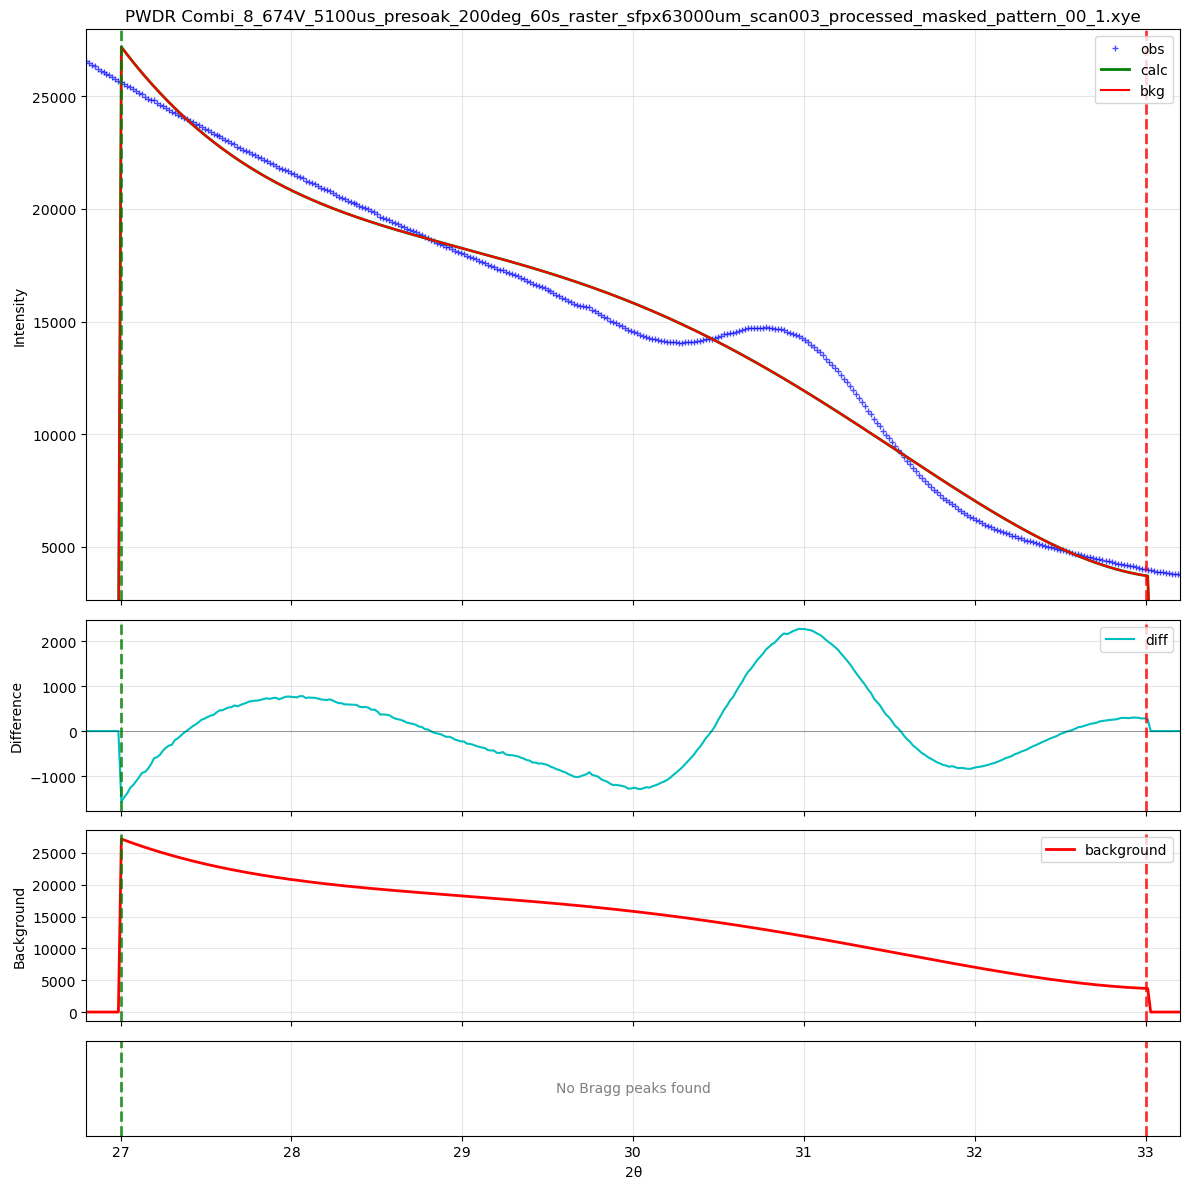

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: title={'center': 'PWDR Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye'}, ylabel='Intensity'>,
        <Axes: ylabel='Difference'>, <Axes: ylabel='Background'>,
        <Axes: xlabel='2θ'>], dtype=object))

In [51]:
""" set refinement parameters --> Not all parameters can be changed this way 
If there are some parameters that you can't change, look up on hist.getHistEntryList()
and change the parameter with hist.setHistEntryValue(['Sample Parameters', 'Type'], 'Bragg-Brentano') """

### This is for changing Diffractometer type to Bragg-Brentano
## Type of sample parameters needs to change with setHistEntryValue
# hist.setHistEntryValue(['Sample Parameters', 'Type'], 'Bragg-Brentano')

# ## Define sample parameters for Bragg-Brentano even if it's not refined
# sample_params = hist.data['Sample Parameters']

# if 'Shift' not in sample_params:
#     sample_params['Shift'] = [0.0, False]  # [value, refine_flag]

# if 'Transparency' not in sample_params:
#     sample_params['Transparency'] = [0.0, False]

# if 'SurfRoughA' not in sample_params:
#     sample_params['SurfRoughA'] = [0.0, False]

# if 'SurfRoughB' not in sample_params:
#     sample_params['SurfRoughB'] = [0.0, False]

# print("Added missing Bragg-Brentano parameters")

# gpx.save()

## Need to load the file again before running refinement 
gpx = G2sc.G2Project(project_name)
hist = gpx.histogram(0)

# # 이제 refinement 실행
refdict = {
    'histograms': [hist]
}
gpx.do_refinements([refdict])
gpx.save()

plot_refinement_result_subplots(gpx, hist_index=0, phase_name="o_HfO2_1")

## project level refinement 
# pardict = {'set': { 'Limits': [21, 24],
#                    'Sample Parameters': ['Absorption', 'Contrast', 'DisplaceX'],
#                    'Background': {'type': 'chebyschev-1', 'refine': True,
#                                   'peaks':[[0,True],[1,1,1]] }},
#           'clear': {'Instrument Parameters': ['U', 'V', 'W']}}

# gpx.do_refinements([pardict])